In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import *
from qiskit_aer import Aer
from qiskit.circuit.library import QFT
from qiskit.circuit.library import Diagonal
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import GroverOperator

from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

In [73]:
def analyse(qc, filename):
    qc = qc.decompose()
    backend_sim = Aer.get_backend("qasm_simulator")
    job_sim = backend_sim.run(qc, shots=2048)
    counts = job_sim.result().get_counts()

    total_counts = sum(counts.values())
    probs = {key: value / total_counts for key, value in counts.items()}
    fig = plot_histogram(probs, title=f"Grover result for value=")
    plt.show()
    fig.savefig(filename)

    # Optionally, print the most probable outcomes
    sorted_counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
    print("Top results:")
    for k, v in list(sorted_counts.items())[:5]:
        print(f"{k} → {v} ({v / 2048:.2%})")

In [74]:
def analyse_freq(qc):
    qc = qc.decompose()
    backend_sim = Aer.get_backend("qasm_simulator")
    job_sim = backend_sim.run(qc, shots=2048)
    counts = job_sim.result().get_counts()

    total_counts = sum(counts.values())

    # Sort by decimal value for consistent ordering
    sorted_items = sorted(counts.items(), key=lambda x: int(x[0], 2))

    labels = []
    values = []
    percents = []
    freqs = {}

    for bitstring, count in sorted_items:
        val_decimal = int(bitstring, 2)
        percent = (count / total_counts) * 100
        labels.append(str(val_decimal))
        values.append(percent)
        percents.append(f"{percent:.2f}%")
        freqs[val_decimal] = f"{percent:.2f}% {bitstring}"

    # Plot histogram with percentage labels
    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, values)

    for bar, pct in zip(bars, percents):
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            yval + 0.5,
            pct,
            ha="center",
            va="bottom",
        )

    plt.xlabel("Value (decimal)")
    plt.ylabel("Frequency (%)")
    plt.title("Quantum Value Frequencies")
    plt.ylim(0, max(values) + 5)
    plt.tight_layout()
    # plt.savefig("filter.png")
    plt.show()

    # Print frequency results
    print(freqs)

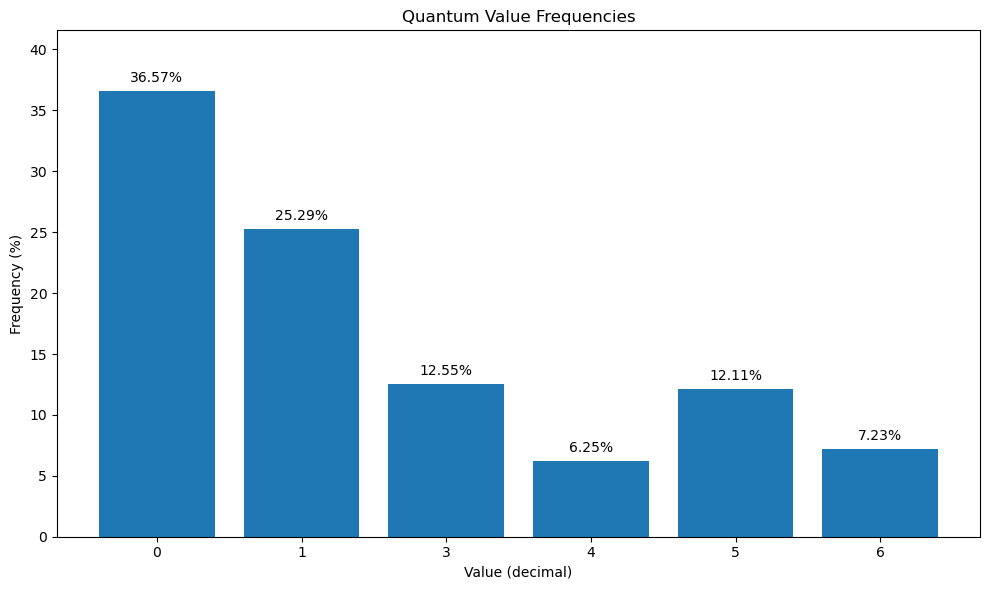

{0: '36.57% 000', 1: '25.29% 001', 3: '12.55% 011', 4: '6.25% 100', 5: '12.11% 101', 6: '7.23% 110'}


In [75]:
L = [1, 6, 5, 3, 1, 1, 3, 4, 1, 5]
n_index = math.ceil(math.log2(len(L)))  # log2(L)
n_val = math.ceil(math.log2(max(L) + 1))  # bits needed to store values (max = 4)

# Quantum circuit: index + value
qc = QuantumCircuit(n_index + n_val, n_val)

idx_qubits = list(range(n_index))
val_qubits = list(range(n_index, n_index + n_val))

# 1. Put pointer into uniform superposition
for i in idx_qubits:
    qc.h(i)

# 2. Encode only valid indices from 0 to len(L) - 1
for idx in range(2**n_index):
    if idx >= len(L):
        continue  # Skip uninitialized (placeholder) memory slots

    val = L[idx]
    idx_bin = format(idx, f"0{n_index}b")
    val_bin = format(val, f"0{n_val}b")

    # Flip index bits for control
    for i, bit in enumerate(idx_bin):
        if bit == "0":
            qc.x(idx_qubits[i])

    # Encode value with multi-controlled X
    for j, bit in enumerate(reversed(val_bin)):
        if bit == "1":
            qc.mcx(idx_qubits, val_qubits[j], mode="noancilla")

    # Unflip index bits
    for i, bit in enumerate(idx_bin):
        if bit == "0":
            qc.x(idx_qubits[i])

qc.barrier(range(n_index + n_val))

# 3. Measure only value qubits (like classical frequency)
for i in range(n_index, n_index + n_val):
    qc.measure(i, i - n_index)

qc.barrier(range(n_index + n_val))

# 4. Simulate & Convert to percentage
analyse_freq(qc)

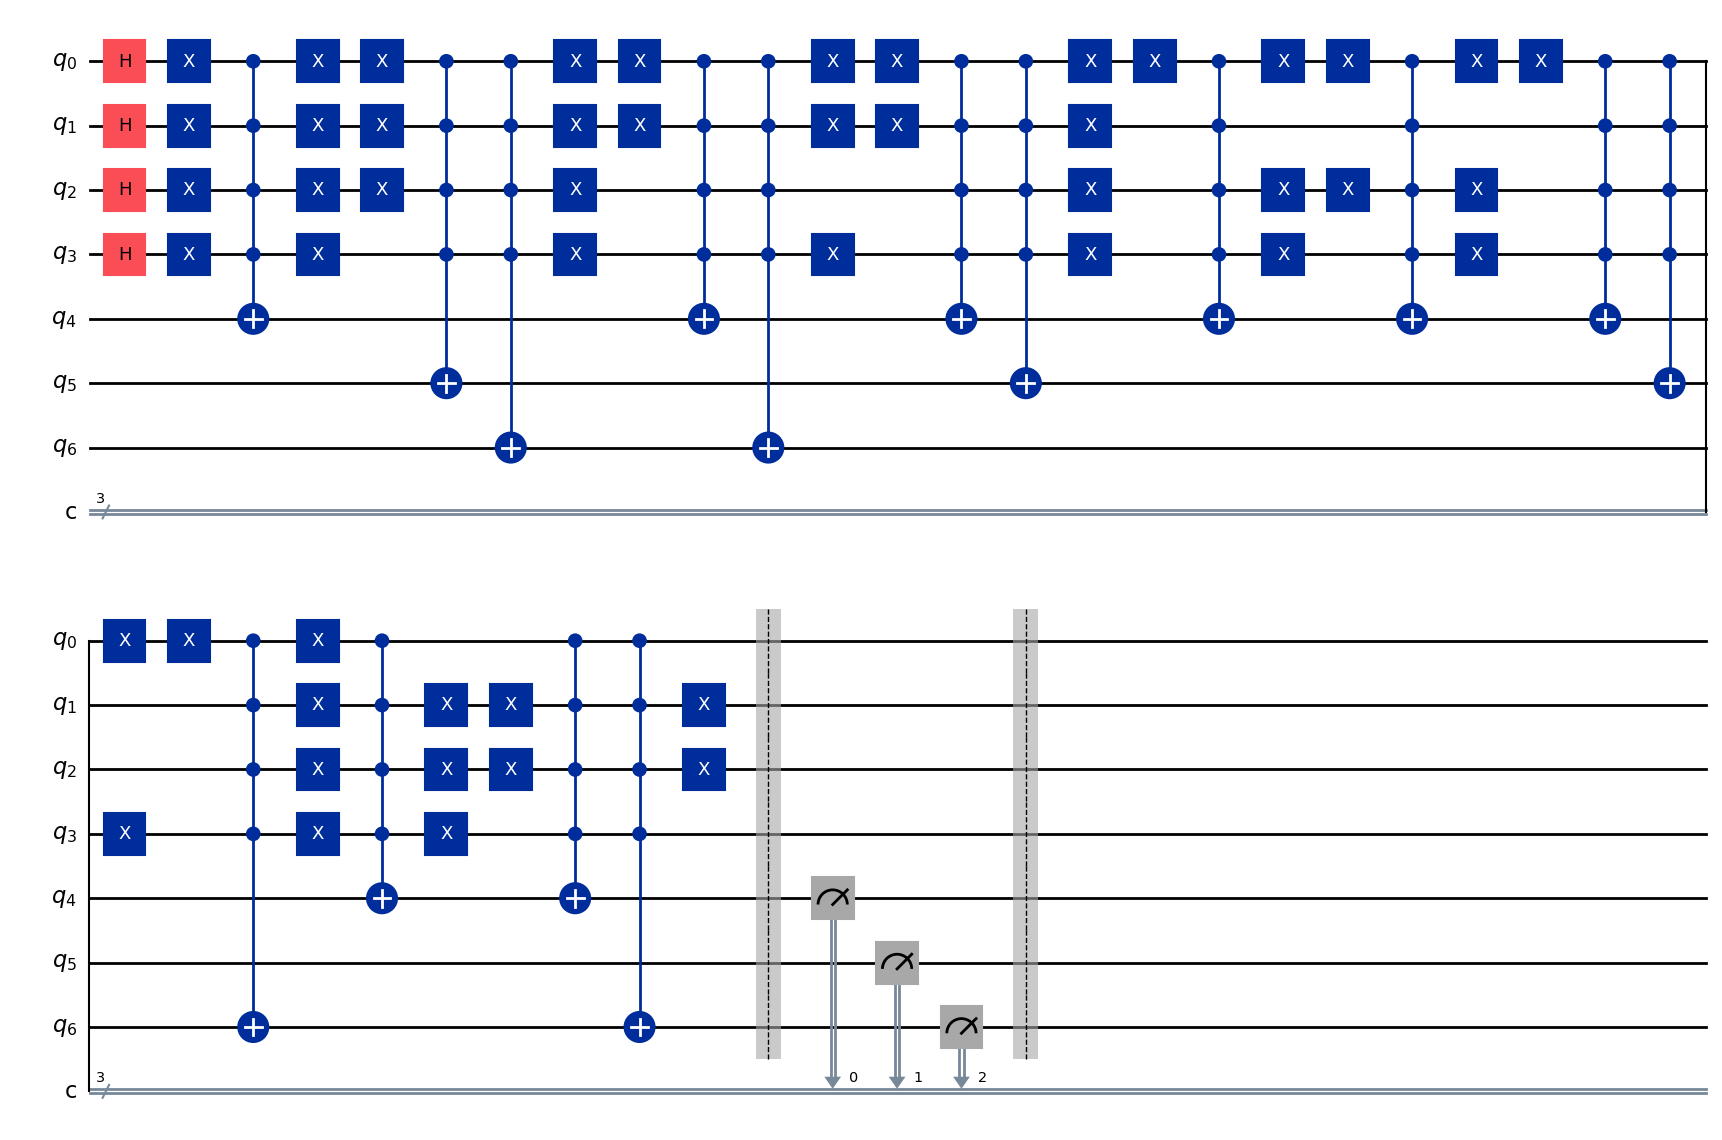

In [76]:
qc.draw(output="mpl", scale=1)

In [77]:
def build_oracle(n_index, n_val, valid_indices, target_bin):
    """
    Oracle flips the phase only when:
      - index qubits match one of the valid indices
      - AND value qubits match the target value
    """
    num_qubits = n_index + n_val
    oracle = QuantumCircuit(num_qubits)

    for idx in valid_indices:
        idx_bin = format(idx, f"0{n_index}b")

        # Apply X gates to index qubits to match `idx`
        for i, bit in enumerate(idx_bin):
            if bit == "0":
                oracle.x(i)

        # Apply X to value qubits where target_bin has 0s
        for j, bit in enumerate(reversed(target_bin)):
            if bit == "0":
                oracle.x(n_index + j)

        # Apply MCX on all qubits: index + value
        all_controls = list(range(num_qubits))
        target = all_controls[-1]
        oracle.h(target)
        oracle.mcx(all_controls[:-1], target)
        oracle.h(target)

        # Uncompute X gates (value qubits first, then index)
        for j, bit in enumerate(reversed(target_bin)):
            if bit == "0":
                oracle.x(n_index + j)
        for i, bit in enumerate(idx_bin):
            if bit == "0":
                oracle.x(i)

    return oracle

In [78]:
def run_grover_search(qc, n_index, n_val, target_value, L):
    val_qubits = list(range(n_index, n_index + n_val))
    target_bin = format(target_value, f"0{n_val}b")
    valid_indices = list(range(len(L)))  # e.g., indices 0 to 9

    oracle = build_oracle(n_index, n_val, valid_indices, target_bin)
    grover_op = GroverOperator(oracle=oracle, insert_barriers=True)

    # Compose Grover operator onto the memory-prepared circuit
    grover_qc = qc.compose(grover_op, front=False)

    # New circuit for measuring only value qubits
    measured_qc = QuantumCircuit(n_index + n_val, n_val)
    measured_qc.compose(grover_qc, inplace=True)

    # Measure only value qubits
    for i in range(n_val):
        measured_qc.measure(n_index + i, i)

    return measured_qc

Target value for Grover: 1


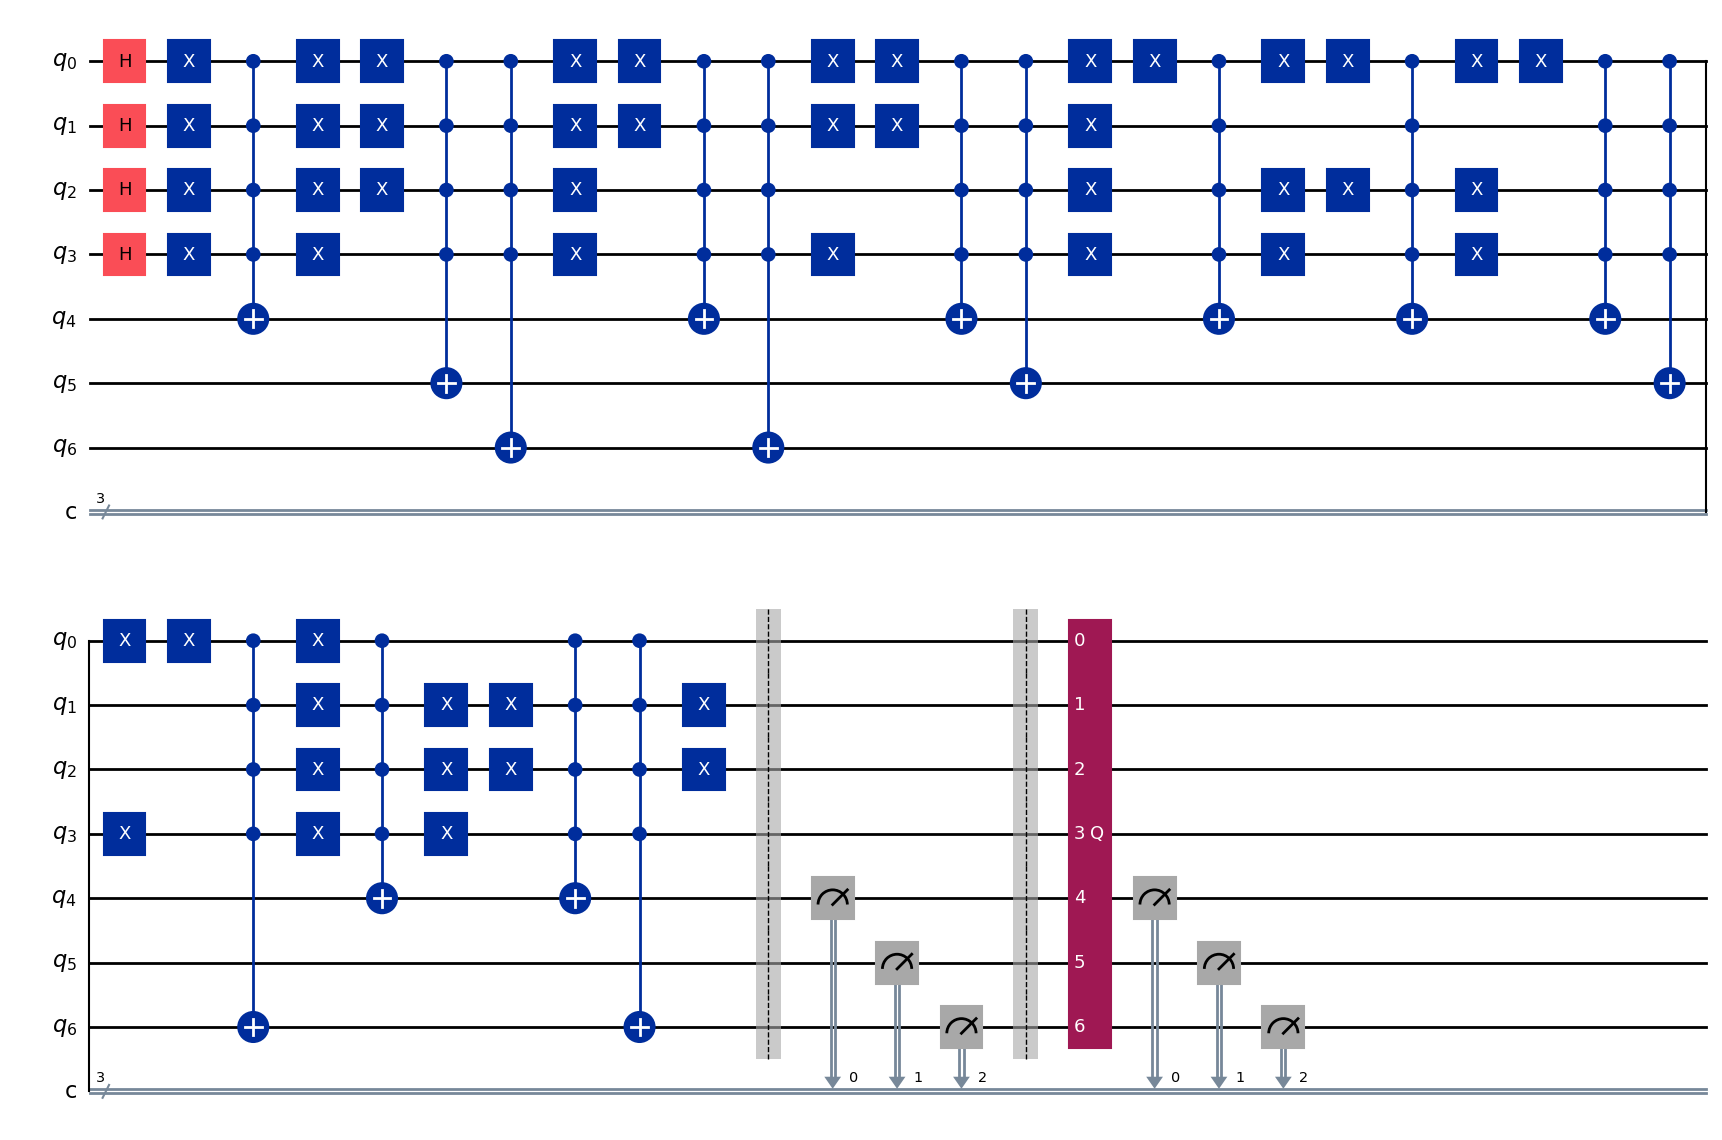

In [79]:
target_value = next(v for v in sorted(set(L)) if v > 0)
print(f"Target value for Grover: {target_value}")

grover_circuit = run_grover_search(qc, n_index, n_val, target_value, L)
grover_circuit.draw(output="mpl", scale=1)

In [172]:
def get_vector(qc):
    backend = Aer.get_backend("statevector_simulator")
    qc_compile = transpile(qc, backend=backend, optimization_level=3)
    statevector = backend.run(qc_compile).result().get_statevector()
    # print(statevector)
    return qc_compile

In [221]:
# ---- Problem data ----
L = [1, 3, 1, 4, 1, 1]  # expect: 0, 2, 4, 5 --> 1, 3, 5, 0
L = [1, 1, 2, 1, 1, 1, 4]
# L = [1, 3, 1, 4, 1, 6]
targets = [1, 1, 1, 4]  # f(x)==True if x==target


def pre_process(L, target, validation):
    M = len(L)
    n = int(np.ceil(np.log2(len(L))))
    total_quibit = 2**n
    if validation != []:
        count_target = sum(
            1 for indx, x in enumerate(L) if x == target and indx in validation
        )
    else:
        count_target = sum(1 for x in L if x == target)
    if count_target / total_quibit == 0.5:
        n += 1
    N = 2**n
    L_pad = L + [None] * (N - len(L))
    return n, N, M, L_pad


def phase_oracle(diagonal):
    """
    Build a single Diagonal gate which applies phase(diagonal[i]) to |i>.
    `diagonal` must be a list or np.array of length 2**n_qubits containing ±1.
    """
    # Create the gate
    oracle_gate = Diagonal(diagonal)
    oracle_gate.name = "Oracle"
    return oracle_gate


def diffuser(n_qubits):
    qc = QuantumCircuit(n_qubits, name="Diffuser")
    qc.h(range(n_qubits))
    qc.x(range(n_qubits))
    qc.h(n_qubits - 1)
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)
    qc.x(range(n_qubits))
    qc.h(range(n_qubits))
    return qc.to_gate()


def inc_modM_gate(n_qubits: int, M: int) -> UnitaryGate:
    """
    Returns an n-qubit gate that maps |i> -> |(i+1) mod M> for i<M,
    and |i> -> |i> for i>=M.
    """
    N = 2**n_qubits
    # start with identity
    P = np.eye(N, dtype=complex)
    # overwrite the rows for 0..M-1
    for i in range(M):
        P[i, i] = 0  # clear the old diagonal entry
        P[(i + 1) % M, i] = 1  # redirect to (i+1)%M
    # rows M..N-1 remain the identity
    return UnitaryGate(P, label=f"inc_mod{M}")


def optimal_grover_iterations(N: int, M: int) -> int:
    """
    Return the optimal number of Grover iterations for
    N total states with M marked states:

        k = floor((pi/4) * sqrt(N/M))

    Args:
        N: total number of basis states (e.g. 2**n)
        M: number of marked states

    Returns:
        k: integer number of iterations
    """
    if M <= 0 or M > N:
        raise ValueError("Require 1 ≤ M ≤ N")
    return math.floor((math.pi / 4) * math.sqrt(N / M))


def pick_top(counts: dict[str, int]) -> int:
    """
    Given a counts dict from Qiskit, return the integer index
    of the most‐measured bitstring.
    """
    bitstr = max(counts, key=counts.get)
    return int(bitstr, 2)


def validation_index(qc):
    backend_sim = Aer.get_backend("qasm_simulator")
    qc_compile = transpile(qc, backend=backend_sim, optimization_level=3)
    job_sim = backend_sim.run(qc_compile, shots=2048)
    counts = job_sim.result().get_counts()

    total_counts = sum(counts.values())
    probs = {int(key, 2): value / total_counts for key, value in counts.items()}
    candidates = [key for key, _ in counts.items()]
    candidates = [int(candidate, 2) for candidate in candidates]
    fig = plot_histogram(probs, title=f"Stat")
    fig.savefig("test")
    return candidates, pick_top(counts)


def build_grover_increment_circuit(n, oracle, diffuser, inc_modM, k):
    q = range(n)
    qc = QuantumCircuit(n, n)
    qc.h(q)
    for _ in range(k):
        qc.append(oracle, q)
        qc.append(diffuser, q)
        qc.append(inc_modM, q)
    qc_compile = get_vector(qc)
    qc.measure(q, q)
    return qc


validation = []
for round_idx, target in enumerate(targets):
    n, N, M, L_pad = pre_process(L, target, validation)

    if round_idx == 0:
        diag = [(-1 if L_pad[i] == target else 1) for i in range(N)]
    else:
        diag = [
            (-1 if (L_pad[i] == target) and (i in validation) else 1) for i in range(N)
        ]
    print(diag)

    oracle_gate = phase_oracle(diag)
    diffuse_gate = diffuser(n)
    inc_modM = inc_modM_gate(n, M)
    module = M if round_idx == 0 else len(validation)
    k = optimal_grover_iterations(N, module) + 1
    print(f'k = {k}')

    qc = build_grover_increment_circuit(n, oracle_gate, diffuse_gate, inc_modM, k)
    validation, top = validation_index(qc)
    print(validation)
    print(top)
    print(f"----------------------")
    if len(validation) == 1:
        break
print(f"The starting index is: {(top - len(targets)) % len(L)}")

[-1, -1, 1, -1, -1, -1, 1, 1]
k = 1
[4, 5, 1, 2, 0, 6, 3, 7]
7
----------------------
[-1, -1, 1, -1, -1, -1, 1, 1]
k = 1
[6, 5, 1, 2, 0, 4, 7, 3]
7
----------------------
[-1, -1, 1, -1, -1, -1, 1, 1]
k = 1
[5, 6, 4, 1, 7, 3, 2, 0]
0
----------------------
[1, 1, 1, 1, 1, 1, -1, 1]
k = 1
[4, 7, 3, 6, 5, 1, 2, 0]
0
----------------------
The starting index is: 3


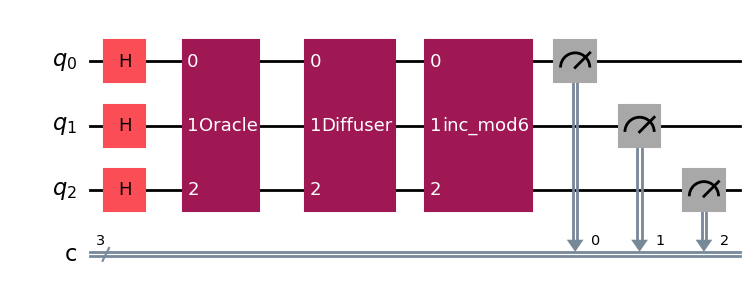

In [187]:
qc.draw(output="mpl", scale=1)

This Qiskit example performs a single Grover iteration on a small list of six elements, then shifts the resulting marked indices by one in a modular fashion.

1. **Initialization**: We use three qubits to represent indices 0 through 5 (padded to eight basis states). Applying Hadamard gates creates an equal superposition of all eight states.

2. **Oracle (Phase Flip)**: A diagonal unitary flips the sign of the amplitude for each basis state whose index points to an element equal to the target value. This encodes the predicate f(i)=True into the quantum phase.

3. **Diffusion (Amplitude Amplification)**: The standard Grover diffuser reflects all amplitudes about their average. This increases the magnitude of the marked states’ amplitudes relative to the others.

4. **Modular Increment**: A custom permutation unitary takes each basis state |i⟩ and maps it to |(i+1) mod 6⟩, leaving the two padded states unchanged. This effectively shifts each amplified index by one, wrapping index 5 back to 0.

5. **Measurement**: Measuring the qubits yields high-probability outcomes exactly at the positions corresponding to the original marked indices plus one (modulo 6). Other indices appear with low background probability.

By following these steps, the circuit highlights the marked elements in the list and then cyclically advances their positions, demonstrating a simple combination of Grover search with modular arithmetic in Qiskit.